Since averaging barcodes together by their respective mutations caused the correlations to weaken, here we will try a bootstrap analysis to see if the correlations are high or low

I will focus on 4 datasets, one pair of outgrowths (NP-11-27-22/23) and the two selection replicated (NP-11-27-24/25). Depending on how this goes I'll try more.

~~First we will model the number of barcodes per mutation with some seemingly appropriate distribution~~
We can just take the barcodes/mutant distribution and randomize barcodes

Next I will reorganize barcodes into fake mutant sets and check the correlation (Pearson). I'll do this 1000 times and generate a distribution of correlations. Finally I will check to see where the correlation value for the actual data falls and assign a bootstrap value.

This notebook will take about half an hour to run because the bootstrapping is a little slow. Switching to 100 times instead of 1000 will bring the run time down.

I also added a segment that trims the selection data for barcodes that appear in the relevant outgrowth (NP-11-27-23) a number of times between an upper and lower cutoff (this didn't improve the result)

In [258]:
# import packages, define correlation function for pairplots 
import numpy as np
import itertools
import math
import pandas as pd
import time
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
import csv
import venn
from numpy import cov
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from numpy import cov
import seaborn as sns
from itertools import islice
import scipy
from scipy.optimize import curve_fit
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from itertools import repeat

pd.set_option('display.max_columns', None)
sns.set(style="white")

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    print('Correlation = ' + str(r))
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


In [157]:
# This information has to be input manually: File names, barcode flank sequences 

datasets = \
    {
    'NP_11_25'    : 'NP_11_25_BCCounts.csv',    # PacBio of glycerol stock
#     'NP_11_24_01' : 'NP_11_24_01_BCCounts.csv', # illumina of glycerol stock
    'NP_11_30_1_1': 'NP_11_30_1_BCCounts.csv',  # illumina of glycerol stock more reads
    'NP_11_24_10' : 'NP_11_24_10_BCCounts.csv', # Glycerol1 full aliquot outgrowth
    'NP_11_24_11' : 'NP_11_24_11_BCCounts.csv', # Glycerol2 full aliquot outgrowth
    'NP_11_24_18' : 'NP_11_24_18_BCCounts.csv', # Glycerol1 outgrowth fewer PCR steps
    'NP_11_24_19' : 'NP_11_24_19_BCCounts.csv', # Glycerol2 outgrowth fewer PCR steps
    'NP_11_27_21' : 'NP_11_27_21_BCCounts.csv', # Glycerol stock pick
    'NP_11_27_22' : 'NP_11_27_22_BCCounts.csv', # Preselection outgrowth (no aTc)
    'NP_11_27_23' : 'NP_11_27_23_BCCounts.csv', # Preselection outgrowth (with aTc)
    'NP_11_27_24' : 'NP_11_27_24_BCCounts.csv', # Selection replicate 1
    'NP_11_27_25' : 'NP_11_27_25_BCCounts.csv'  # Selection replicate 2
    }

PBlookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'
PBallBCs = 'NP_11_25'
illuminaGlycerol = 'NP_11_30_1_1'
outgrowths = list(islice(datasets,2,9))
selections = list(islice(datasets,9,11))

# Make a dataframe with all of the data (each barcode and its frequency in each dataset)
# Switch to outer merges so that all data is retained at each step

BCDF = pd.read_csv(PBlookupTable, index_col = 0).reset_index().rename(columns = {'Barcode_sequence':'Barcode'})

for experiment in datasets:
    dataDF = pd.read_csv(datasets[experiment])
    BCDF = BCDF.merge(dataDF, how = 'outer', on = 'Barcode')


In [158]:
# Get normalized enrichment values on a log scale and perform averages
    
# # # Add 0.01 to each value so that there are no errors
# # naValues = {i : 0.01 for i in listOfFileNames}
# # filledInBCDF = BCDF#.fillna(value=naValues)

# Get enrichment value
# Normalize to total reads
for experiment in datasets:
    if experiment != 'NP_11_25':
        reads = BCDF[experiment]
        totalReads = reads.sum()
        pacbioTotalReads = BCDF['NP_11_25'].sum()
        illuminaTotalReads = BCDF['NP_11_30_1_1'].sum()
        BCDF[experiment + '_norm_enrich'] = np.log((reads/totalReads)/(BCDF['NP_11_30_1_1']/pacbioTotalReads))

# Get enrichment value
# Normalize to total reads
for experiment in selections:
    BCDF[experiment + '_selection_enrich'] = BCDF[experiment + '_norm_enrich'] - BCDF['NP_11_27_23_norm_enrich']


In [159]:
# Get average and std. dev. across mutants for each replicate
# Collapse to one row per mutant in separate dataframe

mutDF = BCDF[['correctedAAmut']].drop_duplicates()
for dataset in ([illuminaGlycerol] + outgrowths + selections):
    if dataset in ([illuminaGlycerol] + outgrowths):
        column = dataset + '_norm_enrich'
    if dataset in selections:
        column = dataset + '_selection_enrich'    
    mutAvgs = BCDF.groupby(['correctedAAmut'])[column].mean().to_frame(name = dataset + '_mutAvgLog')
    mutStDevs = BCDF.groupby(['correctedAAmut'])[column].std().to_frame(name = dataset + '_mutStDevLog')
    mutDF = mutDF.merge(mutAvgs, on = 'correctedAAmut')
    mutDF = mutDF.merge(mutStDevs, on = 'correctedAAmut')
    BCDF = BCDF.merge(mutAvgs, how = 'outer', on = 'correctedAAmut')
    BCDF = BCDF.merge(mutStDevs, how = 'outer', on = 'correctedAAmut')


In [160]:
# Get average of averages, average of standard deviations as new columns
# Separate for outgrowths and selections, all barcodes and mutant

columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_norm_enrich')
BCDF['outgrowths_avg'] = BCDF[columnsToAvg].mean(axis = 1)
BCDF['outgrowths_stDev'] = BCDF[columnsToAvg].std(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_norm_enrich')
BCDF['selections_avg'] = BCDF[columnsToAvg].mean(axis = 1)
BCDF['selections_stDev'] = BCDF[columnsToAvg].std(axis = 1)

# There are two distinct standard deviations here!

columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_mutAvgLog')
mutDF['outgrowths_mut_avg'] = mutDF[columnsToAvg].mean(axis = 1)
mutDF['outgrowths_mut_stDev'] = mutDF[columnsToAvg].std(axis = 1)
columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_mutStDevLog')
mutDF['outgrowths_mut_avg_of_rep_stDevs'] = mutDF[columnsToAvg].mean(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_mutAvgLog')
mutDF['selections_mut_avg'] = mutDF[columnsToAvg].mean(axis = 1)
mutDF['selections_mut_stDev'] = mutDF[columnsToAvg].std(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_mutStDevLog')
mutDF['selections_mut_avg_of_rep_stDevs'] = mutDF[columnsToAvg].mean(axis = 1)



In [161]:
# Add column for barcodes/mutation

BCsPerMut = BCDF['correctedAAmut'].value_counts().to_frame().reset_index().rename(columns = 
                                        {'index': 'correctedAAmut', 'correctedAAmut':'BCsPerMut'})
mutDF = mutDF.merge(BCsPerMut, how = 'outer', on = 'correctedAAmut')


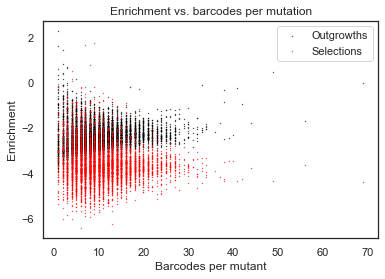

In [162]:
# Scatterplot of enrichment vs. barcodes/mutant for outgrowths and selections

plt.scatter(mutDF['BCsPerMut'], mutDF['outgrowths_mut_avg'], 
            s = 0.1, color = 'black', label = 'Outgrowths')
plt.scatter(mutDF['BCsPerMut'], mutDF['selections_mut_avg'], 
            s = 0.1, color = 'red', label = 'Selections')

plt.title('Enrichment vs. barcodes per mutation')
plt.xlabel('Barcodes per mutant')
plt.ylabel('Enrichment')
plt.legend()

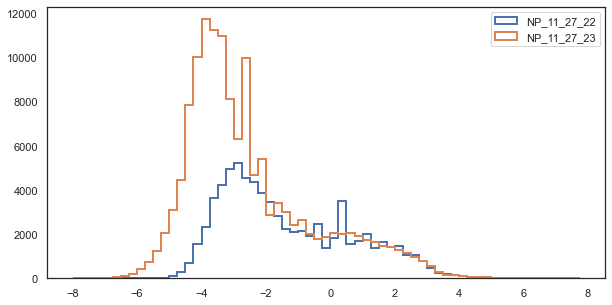

In [163]:
bins = np.arange(-8, 8, 0.25)
plt.figure(figsize=(10, 5))

for experiment in ['NP_11_27_22', 'NP_11_27_23']:
    plt.hist(BCDF[experiment + '_norm_enrich'], 
#              alpha = 0.2,
             histtype = 'step', 
             bins = bins, label = experiment, linewidth = 2)
    

plt.legend()

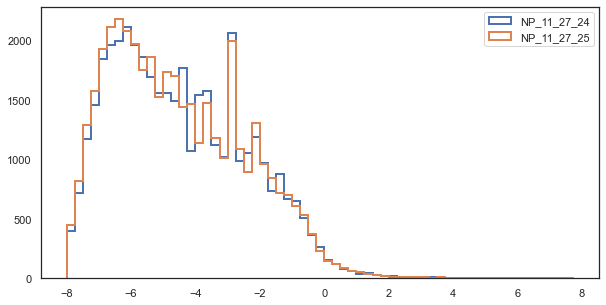

In [164]:
bins = np.arange(-8, 8, 0.25)
plt.figure(figsize=(10, 5))

for experiment in selections:
    plt.hist(BCDF[experiment + '_norm_enrich'], 
#              alpha = 0.2,
             histtype = 'step', 
             bins = bins, label = experiment, linewidth = 2)
    

plt.legend()

Correlation = 0.9368423283814038


Text(0.5, 1.01, 'Pairplot +/- aTc')

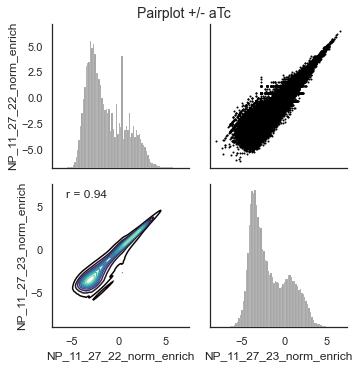

In [165]:
# First get the barcode correlation

pairplotData = BCDF[['NP_11_27_22_norm_enrich', 'NP_11_27_23_norm_enrich']].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Pairplot +/- aTc", y=1.01, size = 14)



Correlation = 0.7347327161764221


Text(0.5, 1.01, 'Pairplot +/- aTc by mutant')

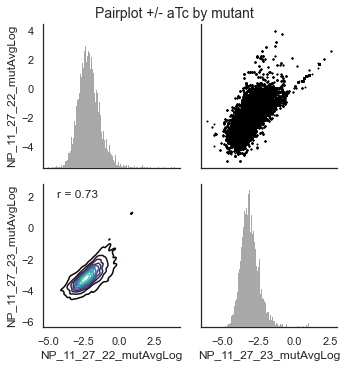

In [166]:
# Next do it for mutants

pairplotData = BCDF[['NP_11_27_22_mutAvgLog', 'NP_11_27_23_mutAvgLog']].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Pairplot +/- aTc by mutant", y=1.01, size = 14)

In [167]:
# Now reset the mutant groupings
# Randomize barcode list, use BCsPerMut as group sizes
# Drop nans

from itertools import repeat

subMutData = mutDF[['NP_11_27_22_mutAvgLog', 'NP_11_27_23_mutAvgLog', 'BCsPerMut']].dropna()

subBCData = BCDF[['NP_11_27_22_mutAvgLog', 'NP_11_27_23_mutAvgLog']].dropna()

corrVals = []

for i in range(1000):
    randBCData = BCDF[['NP_11_27_22_mutAvgLog', 'NP_11_27_23_mutAvgLog']].dropna().sample(frac = 1)

    fakeMuts = []

    for x in range(len(mutDF)):
        fakeMuts.append('FakeMut' + str(x))

    fakeMutCol = []
    for index, row in subMutData.iterrows():
        fakeMutCol.extend(repeat(fakeMuts[index],int(row['BCsPerMut'])))


    randBCData['fakeMut'] = fakeMutCol

    fakeMutDF = randBCData[['fakeMut']]
    # Get average and std. dev. across mutants for each replicate
    # Collapse to one row per mutant in separate dataframe

    fakeMutDF = randBCData[['fakeMut']]
    for dataset in (['NP_11_27_22_mutAvgLog', 'NP_11_27_23_mutAvgLog']): 
        mutAvgs = randBCData.groupby(['fakeMut'])[dataset].mean().to_frame(name = dataset)
        mutStDevs = randBCData.groupby(['fakeMut'])[dataset].std().to_frame(name = dataset + 'StdDev')
        fakeMutDF = fakeMutDF.merge(mutAvgs, on = 'fakeMut')
        fakeMutDF = fakeMutDF.merge(mutStDevs, on = 'fakeMut')

    fakeBCDF = fakeMutDF.drop_duplicates()
    r, _ = stats.pearsonr(fakeBCDF['NP_11_27_22_mutAvgLog'], fakeBCDF['NP_11_27_23_mutAvgLog'])


    corrVals.append(r)
    

Text(0.5, 1.01, 'Pairplot +/- aTc by fake mutant')

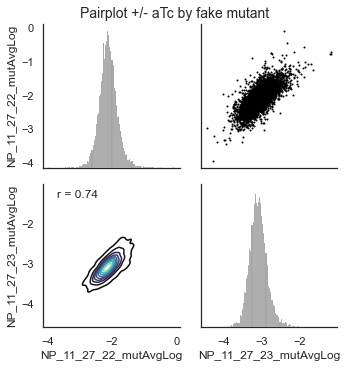

In [133]:
# Next do it for fake mutants

pairplotData = fakeBCDF[['NP_11_27_22_mutAvgLog', 'NP_11_27_23_mutAvgLog']].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Pairplot +/- aTc by fake mutant", y=1.01, size = 14)

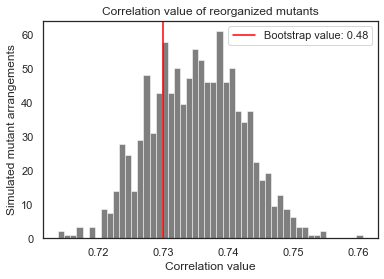

In [174]:
plt.hist(corrVals, bins = 50, density = True, alpha = 0.5, color = 'black')


count = len([i for i in corrVals if i < 0.7347327161764221])
labelText = 'Bootstrap value: ' + str(count/len(corrVals))

plt.axvline(x=0.73, ymin=0, ymax=1, label = labelText, color = 'red')

plt.title('Correlation value of reorganized mutants in outgrowths')
plt.xlabel('Correlation value')
plt.ylabel('Simulated mutant arrangements')
plt.legend()

Correlation = 0.7821524713433788


Text(0.5, 1.01, 'Pairplot +/- aTc')

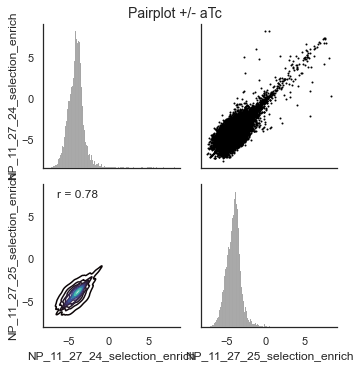

In [176]:
# Now do selections

# First get the barcode correlation

pairplotData = BCDF[['NP_11_27_24_selection_enrich', 'NP_11_27_25_selection_enrich']].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Pairplot +/- aTc", y=1.01, size = 14)

Correlation = 0.4418751120434282


Text(0.5, 1.01, 'Pairplot +/- aTc by mutant')

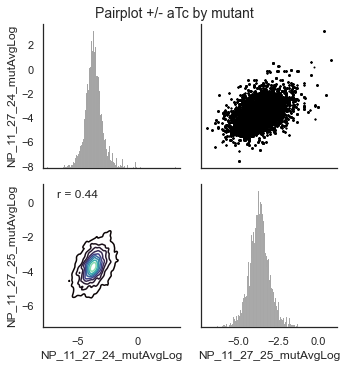

In [177]:
# Next do it for mutants

pairplotData = BCDF[['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog']].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Pairplot +/- aTc by mutant", y=1.01, size = 14)

In [183]:
# Now reset the mutant groupings
# Randomize barcode list, use BCsPerMut as group sizes
# Drop nans


subMutData = mutDF[['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog', 'BCsPerMut']].dropna()

subBCData = BCDF[['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog']].dropna()

corrVals = []

for i in range(1000):
    randBCData = BCDF[['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog']].dropna().sample(frac = 1)

    fakeMuts = []

    for x in range(len(mutDF)):
        fakeMuts.append('FakeMut' + str(x))

    fakeMutCol = []
    for index, row in subMutData.iterrows():
        fakeMutCol.extend(repeat(fakeMuts[index],int(row['BCsPerMut'])))


    randBCData['fakeMut'] = fakeMutCol

    fakeMutDF = randBCData[['fakeMut']]
    # Get average and std. dev. across mutants for each replicate
    # Collapse to one row per mutant in separate dataframe

    fakeMutDF = randBCData[['fakeMut']]
    for dataset in (['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog']): 
        mutAvgs = randBCData.groupby(['fakeMut'])[dataset].mean().to_frame(name = dataset)
        mutStDevs = randBCData.groupby(['fakeMut'])[dataset].std().to_frame(name = dataset + 'StdDev')
        fakeMutDF = fakeMutDF.merge(mutAvgs, on = 'fakeMut')
        fakeMutDF = fakeMutDF.merge(mutStDevs, on = 'fakeMut')

    fakeBCDF = fakeMutDF.drop_duplicates()
    r, _ = stats.pearsonr(fakeBCDF['NP_11_27_24_mutAvgLog'], fakeBCDF['NP_11_27_25_mutAvgLog'])


    corrVals.append(r)
    

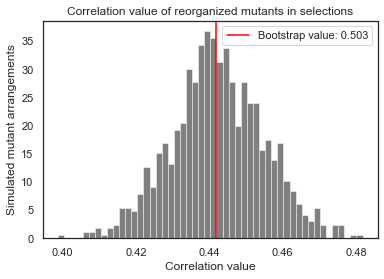

In [184]:
plt.hist(corrVals, bins = 50, density = True, alpha = 0.5, color = 'black')


count = len([i for i in corrVals if i < 0.4418751120434282])
labelText = 'Bootstrap value: ' + str(count/len(corrVals))

plt.axvline(x=0.4418751120434282, ymin=0, ymax=1, label = labelText, color = 'red')

plt.title('Correlation value of reorganized mutants in selections')
plt.xlabel('Correlation value')
plt.ylabel('Simulated mutant arrangements')
plt.legend()

Correlation = 0.5745519867853002


Text(0.5, 1.01, 'Pairplot +/- aTc')

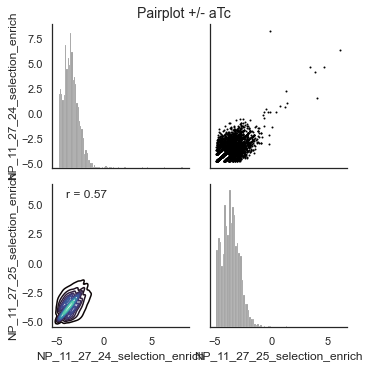

In [261]:
# Now do selections but only barcodes with X reads or more before selection

# First get the barcode correlation

outgrowthReadCutoffLower = 5
outgrowthReadCutoffUpper = 100

moreReadsBCDF = BCDF[(BCDF['NP_11_27_23'] <= outgrowthReadCutoffUpper) 
                    & (BCDF['NP_11_27_23'] >= outgrowthReadCutoffLower)][['NP_11_27_24_selection_enrich', 
                                               'NP_11_27_25_selection_enrich', 
                                               'correctedAAmut']].dropna()

pairplotData = moreReadsBCDF[['NP_11_27_24_selection_enrich', 'NP_11_27_25_selection_enrich']].dropna()

g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Pairplot +/- aTc", y=1.01, size = 14)

In [262]:
# Now reset the mutant groupings
# Randomize barcode list, use BCsPerMut as group sizes
# Drop nans



moreReadsMutDF = subBCData[['correctedAAmut']].drop_duplicates()

# Recalculate averages in limited dataset

for dataset in (selections):
    if dataset in selections:
        column = dataset + '_selection_enrich'    
    mutAvgs = moreReadsBCDF.groupby(['correctedAAmut'])[column].mean().to_frame(name = dataset + '_mutAvgLog')
    moreReadsMutDF = moreReadsMutDF.merge(mutAvgs, on = 'correctedAAmut')
    moreReadsBCDF = moreReadsBCDF.merge(mutAvgs, on = 'correctedAAmut')

BCsPerMut = moreReadsBCDF['correctedAAmut'].value_counts().to_frame().reset_index().rename(columns = 
                                        {'index': 'correctedAAmut', 'correctedAAmut':'BCsPerMut_abundantBCs'})

moreReadsMutDF = moreReadsMutDF.merge(BCsPerMut, how = 'outer', on = 'correctedAAmut')

subMutData = moreReadsMutDF[['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog', 'BCsPerMut_abundantBCs']].dropna()



Correlation = 0.5771761339678068
Correlation = 0.5771761339678068


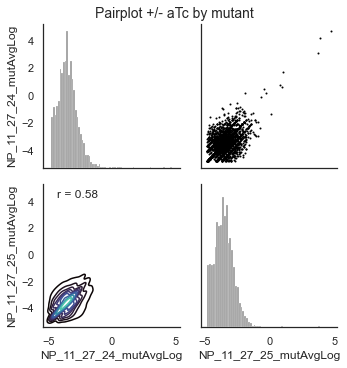

In [263]:
# Next do it for mutants but only barcodes with X reads or more before selection

pairplotData = moreReadsMutDF[['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog']].dropna()


rRealMutsMoreReads, _ = stats.pearsonr(moreReadsMutDF['NP_11_27_24_mutAvgLog'], moreReadsMutDF['NP_11_27_25_mutAvgLog'])


g = sns.PairGrid(pairplotData, palette=["red"])
g.map_upper(plt.scatter, color = 'black', s=1)
g.map_diag(sns.histplot, color = 'grey', kde=False)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap="mako")
g.fig.suptitle("Pairplot +/- aTc by mutant", y=1.01, size = 14)

print('Correlation = ' + str(rRealMutsMoreReads))

In [264]:
# Try out for this subset (>=X reads in outgrowth)
    
corrVals = []

for i in range(1000):
    # Randomize data
    randBCData = moreReadsBCDF[['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog']].dropna().sample(frac = 1)

    fakeMuts = []

    for x in range(len(moreReadsMutDF)):
        fakeMuts.append('FakeMut' + str(x))
        
    # Add the fake mutations to the dataframe
    fakeMutCol = []
    for index, row in subMutData.iterrows():
        fakeMutCol.extend(repeat(fakeMuts[index],int(row['BCsPerMut_abundantBCs'])))

    randBCData['fakeMut'] = fakeMutCol

    fakeMutDF = randBCData[['fakeMut']]
    
    # Get average across fake mutants for each replicate
    # Collapse to one row per mutant in separate dataframe

    fakeMutDF = randBCData[['fakeMut']]
    for dataset in (['NP_11_27_24_mutAvgLog', 'NP_11_27_25_mutAvgLog']): 
        mutAvgs = randBCData.groupby(['fakeMut'])[dataset].mean().to_frame(name = dataset)
        fakeMutDF = fakeMutDF.merge(mutAvgs, on = 'fakeMut')

    fakeBCDF = fakeMutDF.drop_duplicates()
    
    # Calculate correlation
    r, _ = stats.pearsonr(fakeBCDF['NP_11_27_24_mutAvgLog'], fakeBCDF['NP_11_27_25_mutAvgLog'])


    corrVals.append(r)
    

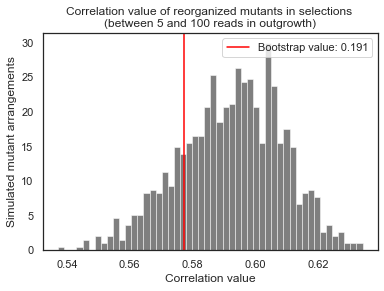

In [268]:
# "high quality" data bootstrap analysis

plt.hist(corrVals, bins = 50, density = True, alpha = 0.5, color = 'black')


count = len([i for i in corrVals if i < rRealMutsMoreReads])
labelText = 'Bootstrap value: ' + str(count/len(corrVals))

plt.axvline(x=rRealMutsMoreReads, ymin=0, ymax=1, label = labelText, color = 'red')

plt.title('''Correlation value of reorganized mutants in selections 
(between {} and {} reads in outgrowth)'''.format(outgrowthReadCutoffLower, outgrowthReadCutoffUpper))
plt.xlabel('Correlation value')
plt.ylabel('Simulated mutant arrangements')
plt.legend()


